
# Food image Identification Project


‎ ‎ ‎ 

**START OF FULFILING BASIC REQUIREMENT (ResNet, VGG, DenseNet & EfficientNet)**

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [3]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [3, 4, 6, 7, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [3, 4, 6, 7, 9]
    name: ['Hokkien Prawn Mee', 'Kaya Toast and Egg', 'Nasi Lemak', 'Oyster Omelette', 'Roti Prata']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



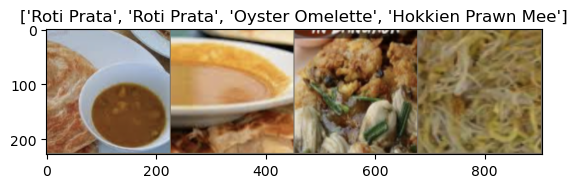

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [6]:
import torch
import copy
import time

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=24):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []  # Initialize an empty list to store training losses

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)  # Store the training loss for this epoch

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer (ResNet)


In [7]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# 2. Modify the pretrain model for your task.
model.fc = nn.Linear(model.fc.in_features, 5)

# 3. Choose your loss function, optimizer, etc.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.2 Printing and visualizing the modified model

In [12]:
# TODO
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# TODO
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [14]:
# Update the call to train_model with the required arguments 'dataloaders' and 'dataset_sizes'
model_resnet18 = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.4889 Acc: 0.2760
val Loss: 1.2105 Acc: 0.4933

Epoch 1/9
----------
train Loss: 1.2449 Acc: 0.5220
val Loss: 0.7575 Acc: 0.7067

Epoch 2/9
----------
train Loss: 0.7185 Acc: 0.7460
val Loss: 0.5313 Acc: 0.8267

Epoch 3/9
----------
train Loss: 0.6116 Acc: 0.7880
val Loss: 0.4085 Acc: 0.8533

Epoch 4/9
----------
train Loss: 0.5601 Acc: 0.7920
val Loss: 0.3762 Acc: 0.8600

Epoch 5/9
----------
train Loss: 0.5403 Acc: 0.7980
val Loss: 0.3182 Acc: 0.8800

Epoch 6/9
----------
train Loss: 0.5076 Acc: 0.8140
val Loss: 0.4254 Acc: 0.8267

Epoch 7/9
----------
train Loss: 0.4650 Acc: 0.8340
val Loss: 0.3254 Acc: 0.8867

Epoch 8/9
----------
train Loss: 0.4005 Acc: 0.8720
val Loss: 0.2969 Acc: 0.8867

Epoch 9/9
----------
train Loss: 0.4503 Acc: 0.8480
val Loss: 0.2997 Acc: 0.8733

Training complete in 2m 51s
Best val Acc: 0.8867


## 5. Loading test data

Define the dataset and dataloader for testing.

In [18]:
test_dir = os.path.join('sg_food','test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

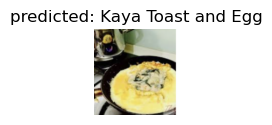

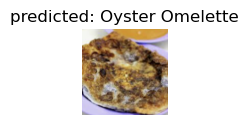

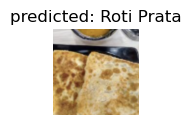

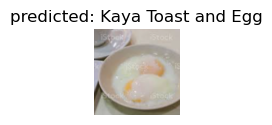

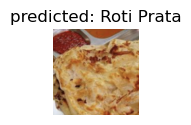

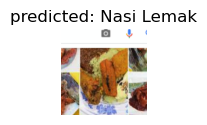

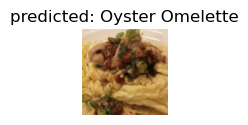

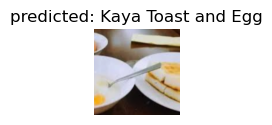

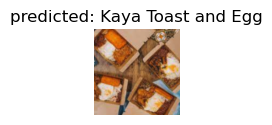

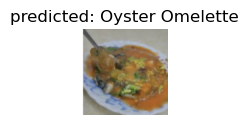

In [16]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 10  # Update num_images to display 10 images

# Predict on the test set
model_resnet18.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            if images_so_far <= num_images:
                ax = plt.subplot(2, 5, min(images_so_far, 10))  # Limit the subplot position to 10
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

    plt.show()  # Display the figure with the images

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [17]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.8810


## 8. Using VGG Model

In [8]:
import torchvision.models as models

# Define VGG model
model_vgg = models.vgg16(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(selected_classes))  # Assuming len(selected_classes) is the number of output classes

# Send model to device (GPU if available)
model_vgg = model_vgg.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model_vgg = train_model(model_vgg, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.5762 Acc: 0.2760
val Loss: 1.2092 Acc: 0.6600

Epoch 1/9
----------
train Loss: 1.0456 Acc: 0.6320
val Loss: 0.5463 Acc: 0.8400

Epoch 2/9
----------
train Loss: 0.5951 Acc: 0.7940
val Loss: 0.3147 Acc: 0.8800

Epoch 3/9
----------
train Loss: 0.5041 Acc: 0.8320
val Loss: 0.2610 Acc: 0.9067

Epoch 4/9
----------
train Loss: 0.4724 Acc: 0.8380
val Loss: 0.3331 Acc: 0.8933

Epoch 5/9
----------
train Loss: 0.4163 Acc: 0.8360
val Loss: 0.2442 Acc: 0.9067

Epoch 6/9
----------
train Loss: 0.3722 Acc: 0.8540
val Loss: 0.3382 Acc: 0.9000

Epoch 7/9
----------
train Loss: 0.3822 Acc: 0.8740
val Loss: 0.2787 Acc: 0.9000

Epoch 8/9
----------
train Loss: 0.3187 Acc: 0.8980
val Loss: 0.2317 Acc: 0.9133

Epoch 9/9
----------
train Loss: 0.2926 Acc: 0.9020
val Loss: 0.2146 Acc: 0.9267

Training complete in 20m 56s
Best val Acc: 0.9267


In [11]:
model_vgg.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_vgg(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.9150


## 9. Using DenseNet

In [12]:
# Define DenseNet model
model_densenet = models.densenet121(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, len(selected_classes))  # Assuming len(selected_classes) is the number of output classes

# Send model to device (GPU if available)
model_densenet = model_densenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model_densenet = train_model(model_densenet, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\yannk/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%


Epoch 0/9
----------
train Loss: 1.7182 Acc: 0.2040
val Loss: 1.5539 Acc: 0.2933

Epoch 1/9
----------
train Loss: 1.5085 Acc: 0.3620
val Loss: 1.2804 Acc: 0.6600

Epoch 2/9
----------
train Loss: 1.2020 Acc: 0.6380
val Loss: 1.0582 Acc: 0.7067

Epoch 3/9
----------
train Loss: 1.0165 Acc: 0.7420
val Loss: 0.8096 Acc: 0.8133

Epoch 4/9
----------
train Loss: 0.8383 Acc: 0.8100
val Loss: 0.6322 Acc: 0.8667

Epoch 5/9
----------
train Loss: 0.6734 Acc: 0.8500
val Loss: 0.5043 Acc: 0.9000

Epoch 6/9
----------
train Loss: 0.5724 Acc: 0.8680
val Loss: 0.4174 Acc: 0.9067

Epoch 7/9
----------
train Loss: 0.5008 Acc: 0.8720
val Loss: 0.4123 Acc: 0.9200

Epoch 8/9
----------
train Loss: 0.4988 Acc: 0.8720
val Loss: 0.4048 Acc: 0.9200

Epoch 9/9
----------
train Loss: 0.5189 Acc: 0.8640
val Loss: 0.3992 Acc: 0.9200

Training complete in 9m 2s
Best val Acc: 0.9200


In [13]:
model_densenet.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_densenet(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.9070


## 10. Using EfficientNet

In [15]:
from efficientnet_pytorch import EfficientNet

# Define EfficientNet model
model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the final fully connected layer
num_ftrs = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(num_ftrs, len(selected_classes))  # Assuming len(selected_classes) is the number of output classes

# Send model to device (GPU if available)
model_efficientnet = model_efficientnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_efficientnet.parameters(), lr=0.001, momentum=0.9)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model_efficientnet = train_model(model_efficientnet, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\yannk/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0
Epoch 0/9
----------
train Loss: 1.6173 Acc: 0.2000
val Loss: 1.5888 Acc: 0.2533

Epoch 1/9
----------
train Loss: 1.5870 Acc: 0.2760
val Loss: 1.5478 Acc: 0.3600

Epoch 2/9
----------
train Loss: 1.5511 Acc: 0.3300
val Loss: 1.4999 Acc: 0.5067

Epoch 3/9
----------
train Loss: 1.5208 Acc: 0.3760
val Loss: 1.4508 Acc: 0.6067

Epoch 4/9
----------
train Loss: 1.4634 Acc: 0.4880
val Loss: 1.4021 Acc: 0.6600

Epoch 5/9
----------
train Loss: 1.4227 Acc: 0.5580
val Loss: 1.3522 Acc: 0.7267

Epoch 6/9
----------
train Loss: 1.3936 Acc: 0.6120
val Loss: 1.3017 Acc: 0.7867

Epoch 7/9
----------
train Loss: 1.3515 Acc: 0.6100
val Loss: 1.2954 Acc: 0.7867

Epoch 8/9
----------
train Loss: 1.3449 Acc: 0.6360
val Loss: 1.2891 Acc: 0.7933

Epoch 9/9
----------
train Loss: 1.3390 Acc: 0.6500
val Loss: 1.2836 Acc: 0.7933

Training complete in 7m 13s
Best val Acc: 0.7933


In [16]:
model_efficientnet.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_efficientnet(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.7450


### Overall verdict:

- Accuracy (Descending)
    - VGG (91.5%)
    
    - DenseNet (90.7%)

    - ResNet18 (88.1%)

    - EfficientNet (74.5%)

To carry on with our experiment, we have chosen ResNet18 and EfficientNet to do the comparison

‎ 

#### Confusion Matrix for both ResNet18 and EfficientNet

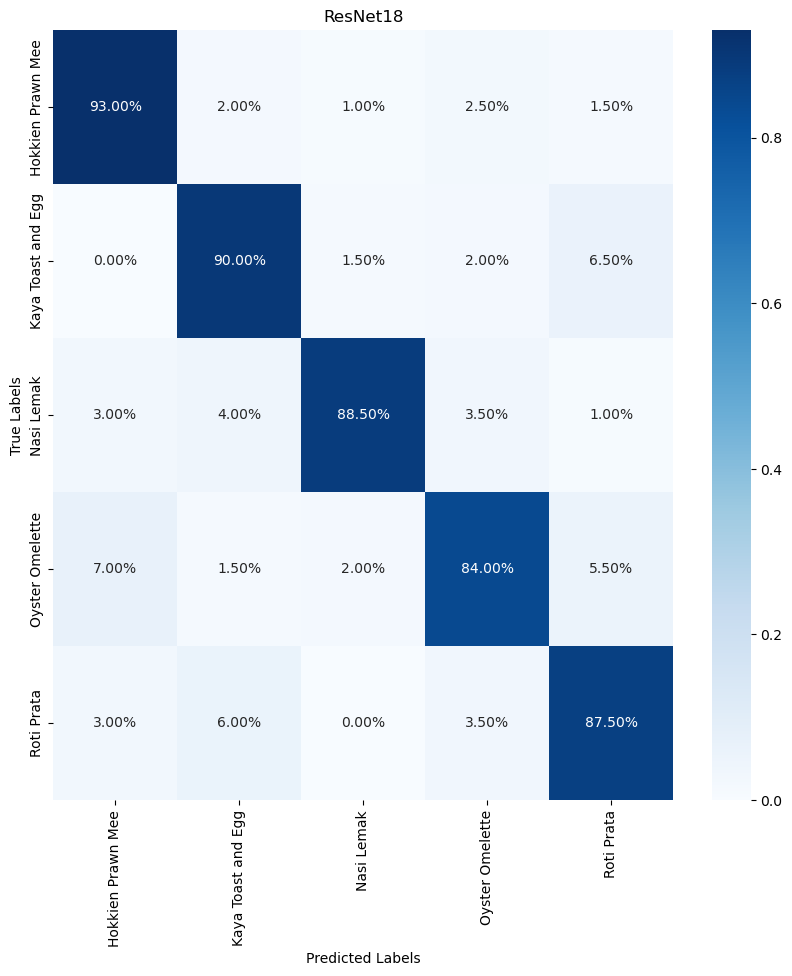

In [28]:
# RESNET18
from sklearn.metrics import confusion_matrix 
import seaborn as sns 
 
# change the model here 
model.eval() 
 
y_true = [] 
y_pred = [] 
 
with torch.no_grad(): 
    # Iterate over the testing dataset 
    for (inputs, labels) in test_loader: 
        inputs = inputs.to(device) 
        labels = labels.to(device) 
        # Predict on the test set 
        outputs = model_resnet18(inputs) 
        _, preds = torch.max(outputs, 1) 
        # Add the true and predicted labels to the lists 
        y_true += labels.tolist() 
        y_pred += preds.tolist() 
 
# Compute confusion matrix 
cm = confusion_matrix(y_true, y_pred) 
 
# Convert confusion matrix values to percentage 
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
 
# Plot confusion matrix as heatmap 
plt.figure(figsize=(10, 10)) 
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.2%', xticklabels=class_names, yticklabels=class_names) 
plt.title('ResNet18')
plt.xlabel('Predicted Labels') 
plt.ylabel('True Labels') 
plt.show()

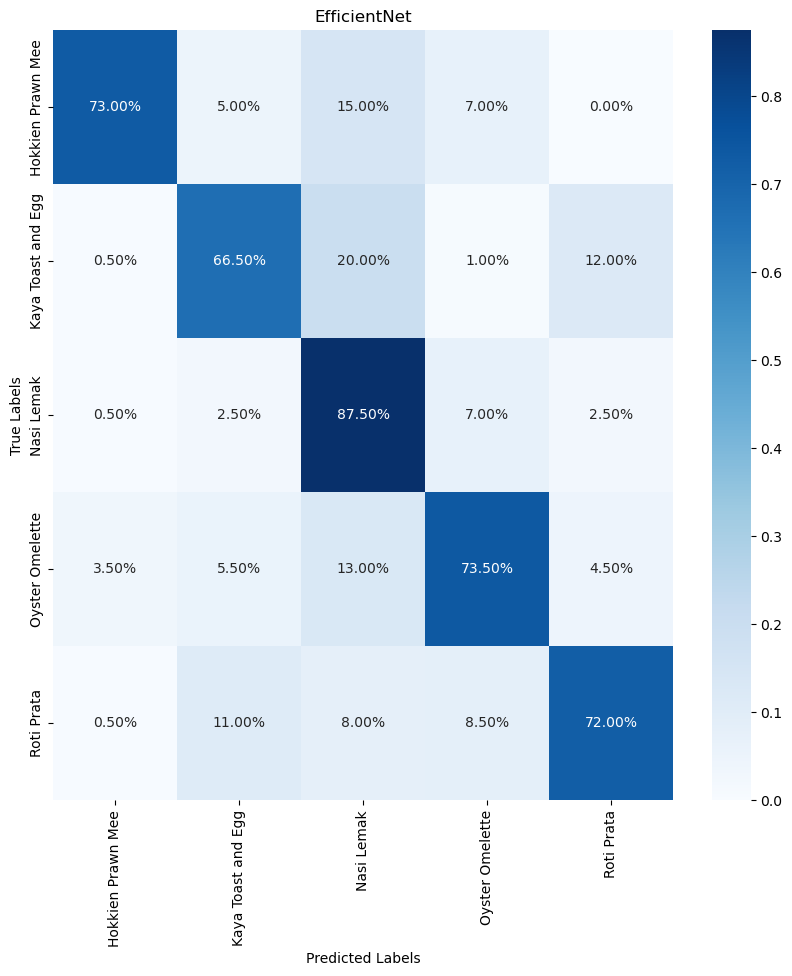

In [31]:
# EFFICIENTNET
from sklearn.metrics import confusion_matrix 
import seaborn as sns 
 
# change the model here 
model_efficientnet.eval() 
 
y_true = [] 
y_pred = [] 
 
with torch.no_grad(): 
    # Iterate over the testing dataset 
    for (inputs, labels) in test_loader: 
        inputs = inputs.to(device) 
        labels = labels.to(device) 
        # Predict on the test set 
        outputs = model_efficientnet(inputs) 
        _, preds = torch.max(outputs, 1) 
        # Add the true and predicted labels to the lists 
        y_true += labels.tolist() 
        y_pred += preds.tolist() 
 
# Compute confusion matrix 
cm = confusion_matrix(y_true, y_pred) 
 
# Convert confusion matrix values to percentage 
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
 
# Plot confusion matrix as heatmap 
plt.figure(figsize=(10, 10)) 
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.2%', xticklabels=class_names, yticklabels=class_names) 
plt.title('EfficientNet')
plt.xlabel('Predicted Labels') 
plt.ylabel('True Labels') 
plt.show()

**END OF FULFILING BASIC REQUIREMENT**

‎ 

**START OF FULFILING ADVANCED REQUIREMENTS**

The **below** portion is to focus on fulfiling the Advanced Requirements (optional) critera.


Advanced Requirements (optional):
You can consider improving the performance of CNN using any or all the following
suggestions:
1. Design your network to handle cases where the test food images do not belong to any
of the 5 target food categories.

2. Design your network to improve the accuracy of recognition.

3. Design your network to reduce the storage requirement or speed up the training
process.

4. You may also suggest other improvements to your model/solution.

‎ 

### POINT 1

*1. Design your network to handle cases where the test food images do not belong to any
of the 5 target food categories.*

To target point 1, we used the following method:
- Utilising **SoftMax Function** to assign decimal probabilities to each class in a multi-class problem. To improve the classification, we have set a threshold of 0.3

- E.g. If any of the food falls below a threshold of 0.3, it is automatically categories as "Unknown", a.k.a not within our 5 target food categories.

In [22]:
import torch.nn.functional as F
from torchvision import transforms

def test_model(model, test_dir, device, threshold=0.5):
    model.eval()
    correct = 0
    total = 0
    in_target_count = 0
    out_target_count = 0

    all_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    target_class_indices = [3, 4, 6, 7, 9]  # Indices of the 5 target categories

    data_transforms = {
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    test_dir = os.path.join('sg_food','test')
    test_dataset = sg_food_dataset(root=test_dir, class_id=all_classes, transform=data_transforms['test'])
    test_sizes = len(test_dataset)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            probs = F.softmax(outputs, dim=1)

            # Get the maximum probability and its index
            max_probs, max_indices = torch.max(probs, dim=1)

            # Check if the maximum probability is above the threshold
            for idx, prob, label in zip(max_indices, max_probs, labels):
                if prob > threshold:
                    predicted_class = classes[idx]
                    if idx in target_class_indices:
                        in_target_count += 1
                    else:
                        out_target_count += 1
                else:
                    predicted_class = "unknown"
                    out_target_count += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Number of images in target categories: {in_target_count}')
    print(f'Number of images outside target categories: {out_target_count}')

    total_count = in_target_count + out_target_count
    print(f'Total number of images: {total_count}')
    assert total_count == test_sizes, "Total count should match the test set size"

# Example usage
test_dir = 'sg_food/test'
threshold = 0.2
test_model(model_resnet18, test_dir, device, threshold)

Number of images in target categories: 846
Number of images outside target categories: 1553
Total number of images: 2399


### Overall verdict for point 1:

*With a threshold of 0.2, it generated the closest output to ideal scenario.*
- Images that belong to the 5 target food categories (846 images).

- Images that do not belong to any of the 5 target food categories (1553 images).

### Ideal output based on the 5 targeted test set:
- Images that belong to the 5 target food categories (1001 images).

- Images that do not belong to any of the 5 target food categories (1398 images).


‎ 

### POINT 2

*2. Design your network to improve the accuracy of recognition.*

To target point 2, we used the following methods:

**Method 1**

*Changing optimisation. From ADAM to SGD*
- SGD is a simpler and more traditional optimization algorithm that performs better with large datasets and complex models compared to adaptive algorithms like Adam.

- With appropriate learning rate scheduling and momentum techniques, SGD can match or exceed the performance of adaptive algorithms while being more computationally efficient.

In [9]:
# OLD CODE
# model = models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = True

# model.fc = nn.Linear(model.fc.in_features, 5)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# NEW CODE
# Change optimiser to SGD
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Update the call to train_model with the required arguments 'dataloaders' and 'dataset_sizes'
model_resnet18 = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.4908 Acc: 0.3600
val Loss: 1.0041 Acc: 0.7133

Epoch 1/9
----------
train Loss: 0.8757 Acc: 0.7160
val Loss: 0.5814 Acc: 0.8467

Epoch 2/9
----------
train Loss: 0.7162 Acc: 0.7600
val Loss: 0.4370 Acc: 0.8533

Epoch 3/9
----------
train Loss: 0.5296 Acc: 0.8120
val Loss: 0.3807 Acc: 0.8867

Epoch 4/9
----------
train Loss: 0.4993 Acc: 0.8340
val Loss: 0.4573 Acc: 0.8267

Epoch 5/9
----------
train Loss: 0.5295 Acc: 0.8160
val Loss: 0.4270 Acc: 0.8333

Epoch 6/9
----------
train Loss: 0.4441 Acc: 0.8380
val Loss: 0.4059 Acc: 0.8467

Epoch 7/9
----------
train Loss: 0.4557 Acc: 0.8460
val Loss: 0.3260 Acc: 0.9000

Epoch 8/9
----------
train Loss: 0.3520 Acc: 0.8700
val Loss: 0.2979 Acc: 0.9200

Epoch 9/9
----------
train Loss: 0.4139 Acc: 0.8620
val Loss: 0.2952 Acc: 0.8800

Training complete in 2m 50s
Best val Acc: 0.9200


In [11]:
test_dir = r"C:\Users\yannk\OneDrive\Desktop\sg_food\test"

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

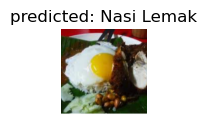

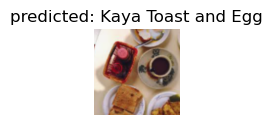

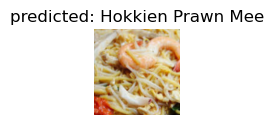

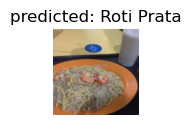

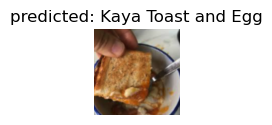

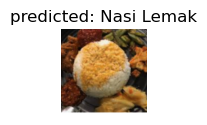

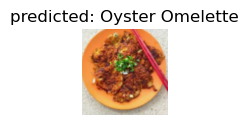

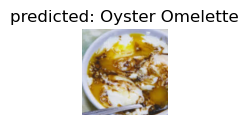

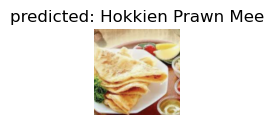

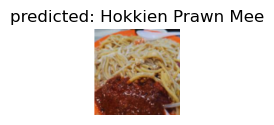

In [12]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 10  # Update num_images to display 10 images

# Predict on the test set
model_resnet18.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            if images_so_far <= num_images:
                ax = plt.subplot(2, 5, min(images_so_far, 10))  # Limit the subplot position to 10
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

    plt.show()  # Display the figure with the images

In [13]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.8820


**Verdict for Method 1:**
- The accuracy of using SGD optimisation did improve slightly of only **0.1137%**.

*Through additional fine-tuning and enhanced precision, the stochastic gradient descent (SGD) optimizer holds the potential to achieve significantly higher accuracy compared to ADAM.*

‎ ‎ ‎ 

### **Method 2**

*uses Automatic Mixed Precision (AMP) training in training model*
- To improve the training speed and memory efficiency of deep neural networks.

- The computations are performed using lower precision (typically half-precision or float16) to take advantage of the faster arithmetic operations and reduced memory footprint.

In [7]:
# NEW CODE, NEW MODEL
from torch.cuda.amp import GradScaler, autocast

def train_model_AMP(model, criterion, optimizer, scheduler, num_epochs=24):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_list = []
    acc_list = []
    
    loss_list_val = []
    acc_list_val = []
    
    # Creates a GradScaler once at the beginning of training.
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Runs the forward pass with autocasting.
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                         # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
                        scaler.scale(loss).backward()
#                         loss.backward()
#                         optimizer.step()

                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
                        # otherwise, optimizer.step() is skipped.
                        scaler.step(optimizer)
                        
                    # Updates the scale for next iteration.
                        scaler.update()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                ## APPEND LOSS AND ACCURACY
                loss_list.append(epoch_loss)
                acc_list.append(epoch_acc)
            else:
                ## APPEND LOSS AND ACCURACY
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        t2=time.time()
        print('Time:'+str(t2-t1))
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Update the call to train_model with the required arguments 'dataloaders' and 'dataset_sizes'
model_resnet18 = train_model_AMP(model, criterion, optimizer, scheduler, num_epochs=10)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 0/9
----------
train Loss: 3.1269 Acc: 0.2720
val Loss: 1.6387 Acc: 0.5467
Time:16.405874729156494

Epoch 1/9
----------
train Loss: 1.7385 Acc: 0.4540
val Loss: 1.4737 Acc: 0.6333
Time:65.79354763031006

Epoch 2/9
----------
train Loss: 1.1566 Acc: 0.6260
val Loss: 0.7137 Acc: 0.7667
Time:22.792720794677734

Epoch 3/9
----------
train Loss: 0.7574 Acc: 0.7260
val Loss: 0.4968 Acc: 0.8267
Time:23.362572193145752

Epoch 4/9
----------
train Loss: 0.6978 Acc: 0.7560
val Loss: 0.4190 Acc: 0.8400
Time:20.74078941345215

Epoch 5/9
----------
train Loss: 0.5588 Acc: 0.8060
val Loss: 0.4431 Acc: 0.8400
Time:17.0745267868042

Epoch 6/9
----------
train Loss: 0.5705 Acc: 0.7840
val Loss: 0.3147 Acc: 0.9000
Time:16.911256074905396

Epoch 7/9
----------
train Loss: 0.4198 Acc: 0.8380
val Loss: 0.3104 Acc: 0.8933
Time:17.33561897277832

Epoch 8/9
----------
train Loss: 0.4017 Acc: 0.8640
val Loss: 0.3147 Acc: 0.8933
Time:17.273574590682983

Epoch 9/9
----------
train Loss: 0.4237 Acc: 0.8580

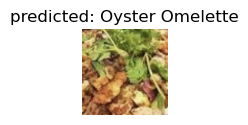

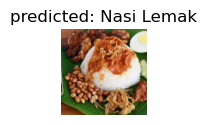

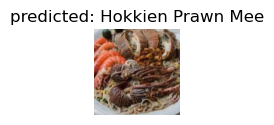

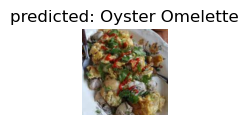

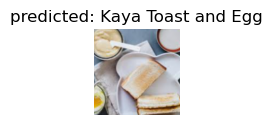

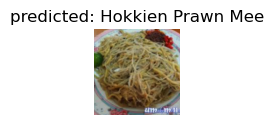

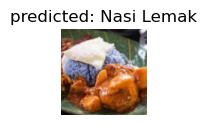

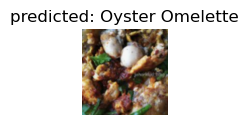

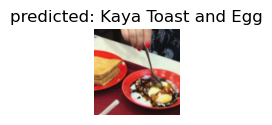

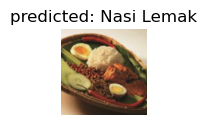

In [9]:
test_dir = r"C:\Users\yannk\OneDrive\Desktop\sg_food\test"

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt
import numpy as np

num_images = 10  # Update num_images to display 10 images

# Predict on the test set
model_resnet18.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            if images_so_far <= num_images:
                ax = plt.subplot(2, 5, min(images_so_far, 10))  # Limit the subplot position to 10
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

    plt.show()  # Display the figure with the images

In [10]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.8840


**Verdict for Method 2:**
- The accuracy of using Automatic Mixed Precision (AMP) training improves by **0.3408%**.

‎ ‎ ‎ 

### **Method 3**

*Using Early Stopping in training model*
- Monitors Validation Performance

- The training is stopped when the validation performance stops improving or starts degrading

In [6]:
# NEW CODE, NEW MODEL w/ Early Stopping
def train_model(model, criterion, optimizer, scheduler, num_epochs, patience=3, min_lr=1e-6, factor=0.1):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stop_counter = 0
    prev_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Deep copy the model if it's the best one
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                val_loss = epoch_loss
                
                # Check for early stopping and reducing learning rate
                if val_loss > prev_val_loss:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print("Early stopping triggered!")
                        return model
                    if optimizer.param_groups[0]['lr'] > min_lr:
                        for param_group in optimizer.param_groups:
                            param_group['lr'] *= factor
                        print("Reducing learning rate to:", optimizer.param_groups[0]['lr'])
                else:
                    early_stop_counter = 0
                    prev_val_loss = val_loss
        
        print()
    
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [7]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# 2. Modify the pretrain model for your task.
model.fc = nn.Linear(model.fc.in_features, 5)

# 3. Choose your loss function, optimizer, etc.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# We have to use more epochs here to see where the Early Stopping is being triggered
model_resnet18 = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 2.1168 Acc: 0.3400
val Loss: 1.6534 Acc: 0.5667

Epoch 2/20
----------
train Loss: 1.1813 Acc: 0.5540
val Loss: 0.7768 Acc: 0.7267

Epoch 3/20
----------
train Loss: 0.7534 Acc: 0.7520
val Loss: 0.4541 Acc: 0.8800

Epoch 4/20
----------
train Loss: 0.6275 Acc: 0.7840
val Loss: 0.3833 Acc: 0.8867

Epoch 5/20
----------
train Loss: 0.5022 Acc: 0.8160
val Loss: 0.3237 Acc: 0.8867

Epoch 6/20
----------
train Loss: 0.5295 Acc: 0.8260
val Loss: 0.3321 Acc: 0.8800
Reducing learning rate to: 0.001

Epoch 7/20
----------
train Loss: 0.4368 Acc: 0.8340
val Loss: 0.3118 Acc: 0.9067

Epoch 8/20
----------
train Loss: 0.4797 Acc: 0.8300
val Loss: 0.3105 Acc: 0.9000

Epoch 9/20
----------
train Loss: 0.4204 Acc: 0.8400
val Loss: 0.3154 Acc: 0.8933
Reducing learning rate to: 1e-05

Epoch 10/20
----------
train Loss: 0.4327 Acc: 0.8600
val Loss: 0.3184 Acc: 0.9000
Reducing learning rate to: 1.0000000000000002e-06

Epoch 11/20
----------
train Loss: 0.4411 Acc: 0.8520

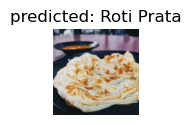

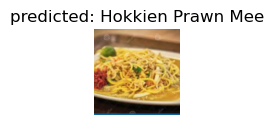

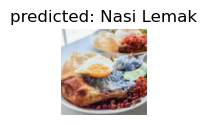

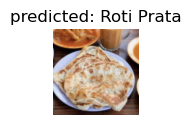

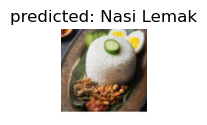

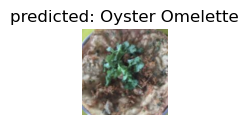

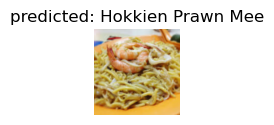

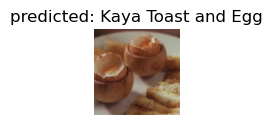

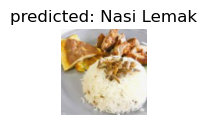

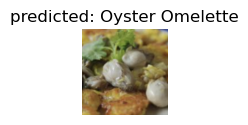

In [9]:
test_dir = r"C:\Users\yannk\OneDrive\Desktop\sg_food\test"

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

import matplotlib.pyplot as plt
import numpy as np

num_images = 10  # Update num_images to display 10 images

# Predict on the test set
model_resnet18.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            if images_so_far <= num_images:
                ax = plt.subplot(2, 5, min(images_so_far, 10))  # Limit the subplot position to 10
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

    plt.show()  # Display the figure with the images

In [10]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.8810


**Verdict for Method 3:**
- The accuracy of using Early Stopping has 0% improvement

‎ ‎ ‎ 

### **Overall verdict for point 2:**

*2. Design your network to improve the accuracy of recognition.*

- Based on the 3 methods, the best outcome was using Automatic Mixed Precision (AMP) as the training model (method 2).

- Achieving an accuracy of 88.4%, as compared to the original 88.1%. Leading an improvement of **0.3408%**

‎ ‎ ‎ 

### POINT 3

*3. Design your network to reduce the storage requirement or speed up the training
process.*

To target point 3, we used the following methods:
- **To reduce storage space:** Use a smaller pre-trained model

- **To speed up training process:** Use a different learning rate schedule (From StepLR to OneCycleLR)

### To reduce storage space

In [14]:
## ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# 2. Modify the pretrain model for your task.
model.fc = nn.Linear(model.fc.in_features, 5)

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
## ResNet34
model = models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# 2. Modify the pretrain model for your task.
model.fc = nn.Linear(model.fc.in_features, 5)

from torchsummary import summary
summary(model, input_size=(3, 224, 224))


c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
## ResNet50
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# 2. Modify the pretrain model for your task.
model.fc = nn.Linear(model.fc.in_features, 5)

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

‎ ‎ ‎ 

### To speed up training process

In [7]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=1000)

model_resnet18 = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yannk\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.6418 Acc: 0.3040
val Loss: 1.1418 Acc: 0.5333

Epoch 1/9
----------
train Loss: 1.1591 Acc: 0.5540
val Loss: 0.8479 Acc: 0.7533

Epoch 2/9
----------
train Loss: 0.8661 Acc: 0.7100
val Loss: 0.6531 Acc: 0.7867

Epoch 3/9
----------
train Loss: 0.6562 Acc: 0.7920
val Loss: 0.5341 Acc: 0.8400

Epoch 4/9
----------
train Loss: 0.6007 Acc: 0.8120
val Loss: 0.4529 Acc: 0.8333

Epoch 5/9
----------
train Loss: 0.5526 Acc: 0.8060
val Loss: 0.3879 Acc: 0.8600

Epoch 6/9
----------
train Loss: 0.4746 Acc: 0.8600
val Loss: 0.3740 Acc: 0.8467

Epoch 7/9
----------
train Loss: 0.4657 Acc: 0.8420
val Loss: 0.3493 Acc: 0.8800

Epoch 8/9
----------
train Loss: 0.5087 Acc: 0.8200
val Loss: 0.3408 Acc: 0.8667

Epoch 9/9
----------
train Loss: 0.4914 Acc: 0.8380
val Loss: 0.3124 Acc: 0.8933

Training complete in 2m 49s
Best val Acc: 0.8933


‎ ‎ ‎ 

### Overall Verdict of Point 3
*3. Design your network to reduce the storage requirement or speed up the training process.*

- **Reduce the storage requirement**

    - As you can see from the 3 ResNet variations, we utilised ResNet18 as it uses the least parameters, thus resulting in using the least storage space of 106 MB.

    - Taking ResNet18(106 MB) as the base: 
        - ResNet34 (178.06 MB, 67.98% increased space)
        
        - ResNet50 (376.84 MB, 257.4% increased space)

‎ 
        

- **Speed up the training process**

    - By comparing both the training process, using StepLR vs OneCycleLR, OneCycleLR has a slight faster training speed

    - OneCycleLR (2mins 49s) vs StepLR (2min 51s)
    
    - OneCycleLR has an increased speed of **1.18%**